In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 

In [4]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# create a relation from unique caracther to integer e viceversa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [7]:
block_size = 3
X,Y = [], []

for w in words:
#     print(w)
    context = [0] * block_size
    for c in w + '.':
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
#         print(f"{''.join(itos[i] for i in context)} ---> {c}")
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
C = torch.randn(27,2)

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)

In [11]:
torch.cat(torch.unbind(emb,1),1)[:4]

tensor([[-1.4051,  1.5790, -1.4051,  1.5790, -1.4051,  1.5790],
        [-1.4051,  1.5790, -1.4051,  1.5790, -2.2094,  0.5994],
        [-1.4051,  1.5790, -2.2094,  0.5994,  0.9914, -1.4793],
        [-2.2094,  0.5994,  0.9914, -1.4793,  0.9914, -1.4793]])

In [12]:
# much more efficient, view() dont copy tensor just the manipulation of the posistion of the number

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [13]:
# second layer, inputs 100 neurons output 27 neurons, for each cara. prediction

W2 = torch.randn(100,27)
b2 = torch.randn(27)

logits = h @ W2 + b2

counts = logits.exp()
prob = counts / counts.sum(1, keepdim = True)

In [15]:
# guardiamo , per i 32 esempi X, la probabilita assegnata al modello per il caratere vero Y
loss = -prob[torch.arange(32),Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [16]:
# --------- more respecatable --------------
X.shape, Y.shape # datasets

(torch.Size([228146, 3]), torch.Size([228146]))

In [27]:
# --------- more respecatable --------------
g = torch.Generator(device = device).manual_seed(2147483647)
C = torch.randn(27,2, generator = g, device = device)
W1 = torch.randn(6,100, generator = g, device = device)
b1 = torch.randn(100, generator = g, device = device)
W2 = torch.randn(100,27, generator = g, device = device)
b2 = torch.randn(27, generator = g, device = device)
parameters = [C,W1,b1,W2,b2]

In [18]:
sum(p.nelement() for p in parameters) # number of parameters in the mdodel

3481

In [19]:
# cross entropy
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim = True)
# loss = -prob[torch.arange(32),Y].log().mean()

In [20]:
for p in parameters:
    p.requires_grad = True

loss of just the minibacth 5.004647731781006


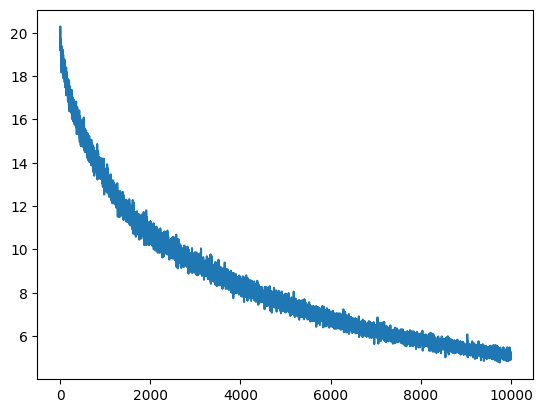

In [21]:
lossi = []

for _ in range(10000):
    # minibatch
    ix = torch.randint(0,X.shape[0], (1000,)) # prevela 32 esempi rand da X
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # more efficient, same as above but with pytorch
    # best prat.
    loss = F.cross_entropy(logits, Y[ix])
    loss
    
    #bacward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.0005 * p.grad # how to determind learning rate
    
    # stats
    lossi.append(loss.item())
# calcolare il gradiente solo su 32 esempi rand alla volta, rispetto 
# che su tutto il db, lo fa diventare non accurato, ma la velcita di
# e piu alta e ci permette di fare piu iterazioni ed arrivare
# al minimo di loss + velocemente.
plt.plot(lossi)
print("loss of just the minibacth",loss.item())

In [22]:
# loss of all the database post training
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print("loss of all db", loss.item())

loss of all db 5.091203689575195


In [23]:
# divide the db: training split, dev/valid split, test split
# 80%, 10%, 10%
# 1- training the parameters
# 2- training the iperparameters
# 3- test for final review